# With TF

In [42]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras.utils import image_dataset_from_directory
from keras.applications import vgg16
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt

In [43]:
def show_image(image_list, label_list= None):
    """Plot images."""
    
    fig = plt.figure(figsize=(10, 5))
    for i, file in enumerate(image_list):
        
        # if image is numpy array
        if isinstance(file, np.ndarray):
            img= file.astype(np.int32)
        # if image is PIL image
        else:
            img = np.array(file, dtype= np.int32)
        
        print('Image shape:', img.shape)
        ax = fig.add_subplot(2, int(len(image_list)/2), i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)
    
        if label_list is not None:
            ax.set_title(label_list[i])
    
    plt.tight_layout()
    plt.show()

## Load Dataset

In [44]:
train_path= 'dataset/dogs-vs-cat/train'
valid_path= 'dataset/dogs-vs-cat/valid'
test_path= 'dataset/dogs-vs-cat/test'
batch_size= 8

train_ds= image_dataset_from_directory(
    train_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'binary',
)
val_ds= image_dataset_from_directory(
    valid_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'binary',
)
test_ds= image_dataset_from_directory(
    test_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'binary',
)

Found 402 files belonging to 2 classes.
Found 103 files belonging to 2 classes.
Found 251 files belonging to 2 classes.


Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


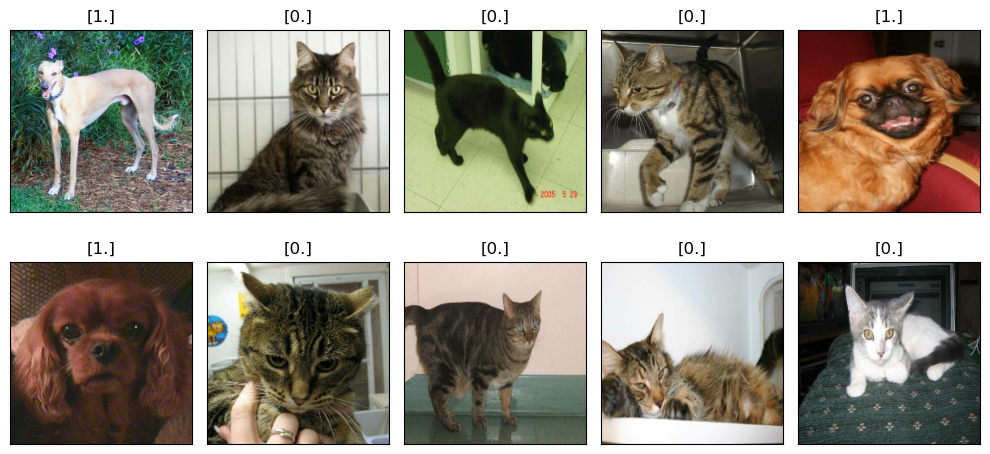

In [45]:
samples= train_ds.unbatch().take(10)
images= []
labels= []

for (image, label) in samples.as_numpy_iterator():
    images.append(image)
    labels.append(label)

show_image(images, labels)

## Create Model

In [46]:
base_model= vgg16.VGG16(include_top= False, 
                        weights= 'imagenet', 
                        input_shape= (224, 224, 3),
                        )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [47]:
# freeze all layers
for layer in base_model.layers:
    layer.trainable= False

In [48]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [49]:
last_layer= base_model.get_layer(index= -1)
last_layer_output= last_layer.output
last_layer_output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [50]:
# preprocessing
data_augmentation= keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

In [51]:
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs) # data augmentation

x = vgg16.preprocess_input(x) # apply input value scaling

x = base_model(x) # run through VGG16

x= Flatten()(x)

x= Dense(64, activation= 'relu', name= 'FC_2')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

x= Dense(32, activation= 'relu', name= 'FC_3')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

x= Dense(16, activation= 'relu', name= 'FC_4')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

outputs= Dense(1, activation= 'sigmoid', name= 'sigmoid')(x)

new_model= Model(inputs= inputs, outputs= outputs)
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0   

In [52]:
new_model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)

In [53]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="output/cat_dog_pretrained.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

epochs = 10
history = new_model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)

Epoch 1/10
13/13 [==============================] - 67s 5s/step - loss: 0.5378 - accuracy: 0.7289 - val_loss: 0.2866 - val_accuracy: 0.8835
Epoch 2/10
13/13 [==============================] - 63s 5s/step - loss: 0.3517 - accuracy: 0.8383 - val_loss: 0.1561 - val_accuracy: 0.9223
Epoch 3/10
13/13 [==============================] - 63s 5s/step - loss: 0.2572 - accuracy: 0.8930 - val_loss: 0.1493 - val_accuracy: 0.9417
Epoch 4/10
13/13 [==============================] - 59s 5s/step - loss: 0.2101 - accuracy: 0.9229 - val_loss: 0.1689 - val_accuracy: 0.9417
Epoch 5/10
13/13 [==============================] - 61s 5s/step - loss: 0.1949 - accuracy: 0.9378 - val_loss: 0.2081 - val_accuracy: 0.9029
Epoch 6/10
13/13 [==============================] - 60s 5s/step - loss: 0.1733 - accuracy: 0.9453 - val_loss: 0.1813 - val_accuracy: 0.9126
Epoch 7/10
13/13 [==============================] - 60s 5s/step - loss: 0.1134 - accuracy: 0.9701 - val_loss: 0.1216 - val_accuracy: 0.9515
Epoch 8/10
13/13 [==

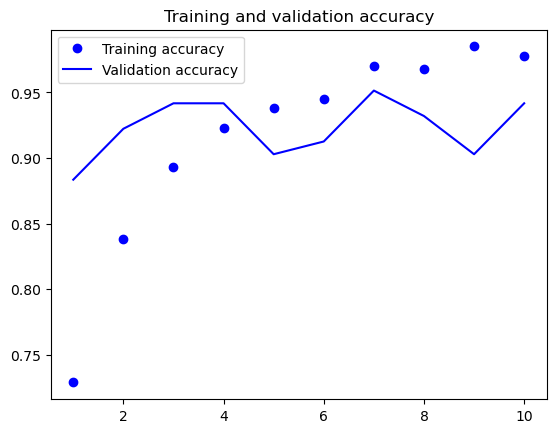

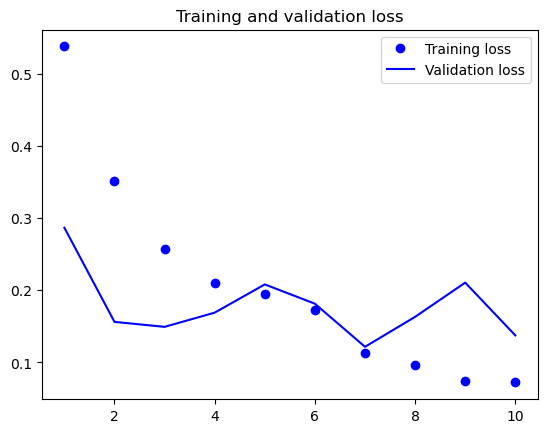

In [54]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [55]:
test_loss, test_acc= new_model.evaluate(test_ds)
print('Pretrained:')
print(f'Test accuracy = {test_acc: .4f} - test loss = {test_loss: 4f}')

8/8 [==============================] - 28s 4s/step - loss: 0.1107 - accuracy: 0.9681
Pretrained:
Test accuracy =  0.9681 - test loss =  0.110733


Now we try again with finetuning the last 4 layers of convolutional layers.
1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we
added.

We have completed the first three steps.

In [56]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [57]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [58]:
# recomiple the model to apply change
new_model.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), 
    metrics = ['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="output/cat_dog_pretrained_tuned.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

epochs = 10
history = new_model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)

Epoch 1/10
13/13 [==============================] - 73s 5s/step - loss: 0.0752 - accuracy: 0.9851 - val_loss: 0.1277 - val_accuracy: 0.9417
Epoch 2/10
13/13 [==============================] - 73s 6s/step - loss: 0.0648 - accuracy: 0.9851 - val_loss: 0.1577 - val_accuracy: 0.9320
Epoch 3/10
13/13 [==============================] - 70s 5s/step - loss: 0.0746 - accuracy: 0.9801 - val_loss: 0.1598 - val_accuracy: 0.9320
Epoch 4/10
13/13 [==============================] - 70s 5s/step - loss: 0.0565 - accuracy: 0.9925 - val_loss: 0.1544 - val_accuracy: 0.9320
Epoch 5/10
13/13 [==============================] - 70s 5s/step - loss: 0.0742 - accuracy: 0.9826 - val_loss: 0.1516 - val_accuracy: 0.9223
Epoch 6/10
13/13 [==============================] - 69s 5s/step - loss: 0.0401 - accuracy: 1.0000 - val_loss: 0.1524 - val_accuracy: 0.9223
Epoch 7/10
13/13 [==============================] - 69s 5s/step - loss: 0.0510 - accuracy: 0.9925 - val_loss: 0.1452 - val_accuracy: 0.9417
Epoch 8/10
13/13 [==

In [59]:
test_loss, test_acc= new_model.evaluate(test_ds)
print('Pretrained fine-tuned:')
print(f'Test accuracy = {test_acc: .4f} - test loss = {test_loss: 4f}')

8/8 [==============================] - 27s 3s/step - loss: 0.0588 - accuracy: 0.9801
Pretrained fine-tuned:
Test accuracy =  0.9801 - test loss =  0.058816


# With Pytorch

In [60]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F

from pathlib import Path
import os
from PIL import Image
import numpy as np

In [61]:
batch_size= 8

transforms_train= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transforms_test= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transforms_label= transforms.Compose([
    transforms.ToTensor(),
    lambda x: F.one_hot(x, -1)
])

# train
dir_= Path('dataset/dogs-vs-cat/train')
train_set= datasets.ImageFolder(
    dir_, 
    transform= transforms_train, 
)
train_dl= DataLoader(
    train_set,
    batch_size= batch_size,
    shuffle= True
)

# validation
dir_= Path('dataset/dogs-vs-cat/valid')
val_set= datasets.ImageFolder(
    dir_, 
    transform= transforms_train,
)
val_dl= DataLoader(
    val_set, 
    batch_size= 
    batch_size, 
    shuffle= True
)

# test
dir_= Path('dataset/dogs-vs-cat/test')
test_set= datasets.ImageFolder(
    dir_, 
    transform= transforms_test,
)
test_dl= DataLoader(
    test_set, 
    batch_size= batch_size, 
    shuffle= False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


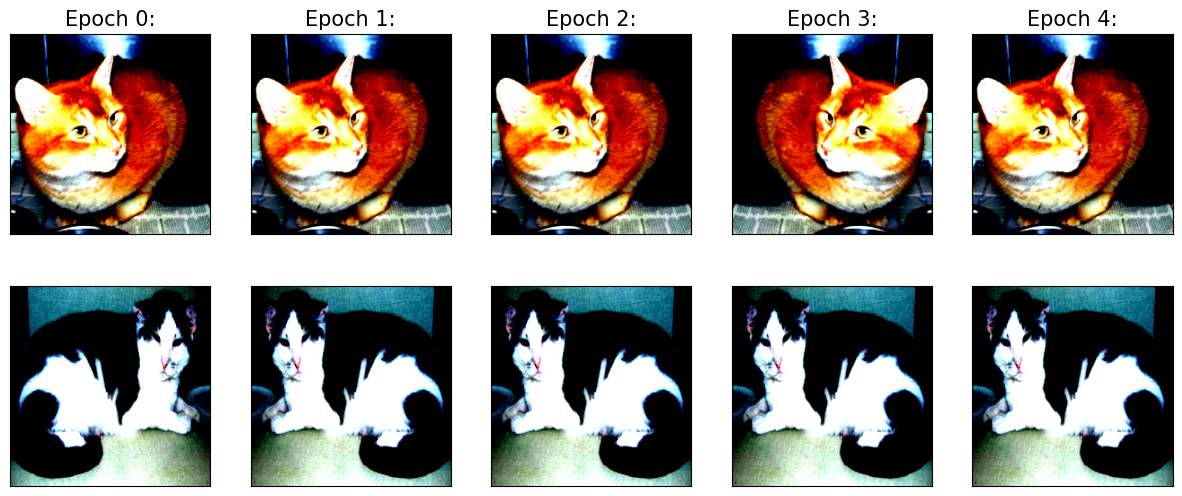

In [62]:
batch_size = 2
augment_samples= DataLoader(train_set, batch_size= batch_size)

fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(augment_samples))
    
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

In [63]:
base_model= models.vgg16(weights='IMAGENET1K_V1')
base_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [64]:
base_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [65]:
base_model.classifier[-1].out_features

1000

In [66]:
base_model.classifier.add_module(
    name= 'binary_clf', 
    module= nn.Linear(
        in_features= base_model.classifier[-1].out_features, 
        out_features= 2)
)

In [67]:
base_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (binary_clf): Linear(in_features=1000, out_features=2, bias=True)
)

In [68]:
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(base_model.parameters(), lr= 0.0001)

n_epochs= 1
log_print= 1

n_train_samples= len(train_dl.dataset)
n_val_samples= len(val_dl.dataset)

In [69]:
acc_hist_train= [0] * n_epochs
acc_hist_val= [0] * n_epochs

loss_hist_train= [0] * n_epochs
loss_hist_val= [0] * n_epochs

for epoch in range(n_epochs):

    base_model.train()
    for x_batch, y_batch in train_dl:
        
        y_pred_logits= base_model(x_batch)
        # loss= loss_fn(y_pred_logits, y_pred)
        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()
        
        # y_pred= torch.argmax(y_pred_logits, dim= 1)
        # true_pred= (y_pred == y_batch)
        
        print(y_pred_logits, y_batch)
        break

tensor([[-1.3641,  0.0776],
        [-0.5431, -0.5004],
        [-1.3053, -1.0413],
        [-1.5147, -1.5572],
        [ 0.4884, -1.2757],
        [ 6.6495, -0.3495],
        [ 0.1815,  1.3359],
        [ 0.6926, -1.9549]], grad_fn=<AddmmBackward0>) tensor([1, 1, 1, 1, 1, 0, 1, 1])


In [70]:
tensor = [
    [-1.4113, -0.0262],
    [0.3583, -1.4708],
    [-0.8076, -1.6834],
    [0.2654, -1.1023],
    [2.9400, 0.7721],
    [-0.2965, -0.9601],
    [1.5183, 0.9368],
    [-1.2978, -0.4997],
]
t = torch.Tensor(tensor)
label = torch.LongTensor([1, 0, 0, 1, 0, 1, 1, 1])
label.reshape(-1, 1)

tensor([[1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1]])